# Practica 2: Modelos de Clasificacion de Credito - COMPLETA

**Objetivo:** Implementar y optimizar modelos para clasificacion binaria.

**Contexto:** Coste de FP (dar credito no devuelto) = 4x coste FN (no dar credito devuelto).

In [35]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV, StratifiedKFold
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB

from sklearn.metrics import (classification_report, confusion_matrix,
                             roc_auc_score, roc_curve, accuracy_score,
                             precision_score, recall_score, f1_score)

%matplotlib inline
plt.style.use('seaborn-v0_8-darkgrid')
plt.rcParams['figure.figsize'] = (14, 6)

print('LIBRERIAS IMPORTADAS')

LIBRERIAS IMPORTADAS


## Apartado A: Analisis Exploratorio (EDA)

In [36]:
df = pd.read_csv('credit_practice_dataset.csv')

print('EXPLORACION INICIAL')
print('Filas:', df.shape[0], ', Columnas:', df.shape[1])
print(df.head())
print(df.isnull().sum())
print(df.describe())

EXPLORACION INICIAL
Filas: 1000 , Columnas: 28
   row_id  age_years  employment_length_years  annual_income_eur  \
0       1         37                      2.7              63530   
1       2         51                     22.0              20626   
2       3         51                      3.6              12999   
3       4         58                      0.1              51962   
4       5         22                      4.1              16081   

   loan_amount_eur  loan_duration_months  num_past_due  num_open_loans  \
0            25383                    48             0               2   
1             9969                    24             0               2   
2            11994                    36             0               7   
3             7525                    48             0               0   
4            44044                    36             3               2   

   credit_history_length_years  savings_balance_eur  ...  num_dependents  \
0                      


DISTRIBUCION DE CLASES:
returned_credit
1    700
0    300
Name: count, dtype: int64

Proporcion:
returned_credit
1    0.7
0    0.3
Name: proportion, dtype: float64


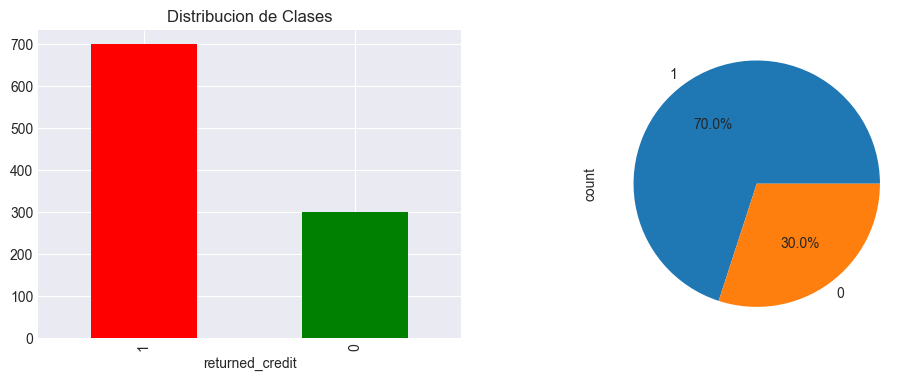

In [37]:
print('\nDISTRIBUCION DE CLASES:')
print(df['returned_credit'].value_counts())
print('\nProporcion:')
print(df['returned_credit'].value_counts(normalize=True))

fig, axes = plt.subplots(1, 2, figsize=(12, 4))
df['returned_credit'].value_counts().plot(kind='bar', ax=axes[0], color=['red', 'green'])
axes[0].set_title('Distribucion de Clases')
df['returned_credit'].value_counts().plot(kind='pie', ax=axes[1], autopct='%1.1f%%')
plt.show()

Correlaciones con target:
returned_credit                     1.000000
annual_income_eur                   0.254353
checking_balance_eur                0.104871
has_phone                           0.065622
row_id                              0.057556
commute_distance_km                 0.057377
installment_rate_pct                0.037555
has_guarantor                       0.037360
foreign_worker                      0.027999
smartphone_usage_hours              0.016644
online_purchase_count_last_month    0.003236
digital_literacy_score             -0.002737
num_open_loans                     -0.004977
employment_length_years            -0.010885
num_dependents                     -0.012632
age_years                          -0.019962
credit_history_length_years        -0.021625
loan_duration_months               -0.024783
late_night_activity_ratio          -0.026913
savings_balance_eur                -0.040765
cash_withdrawal_ratio              -0.043691
num_past_due                 

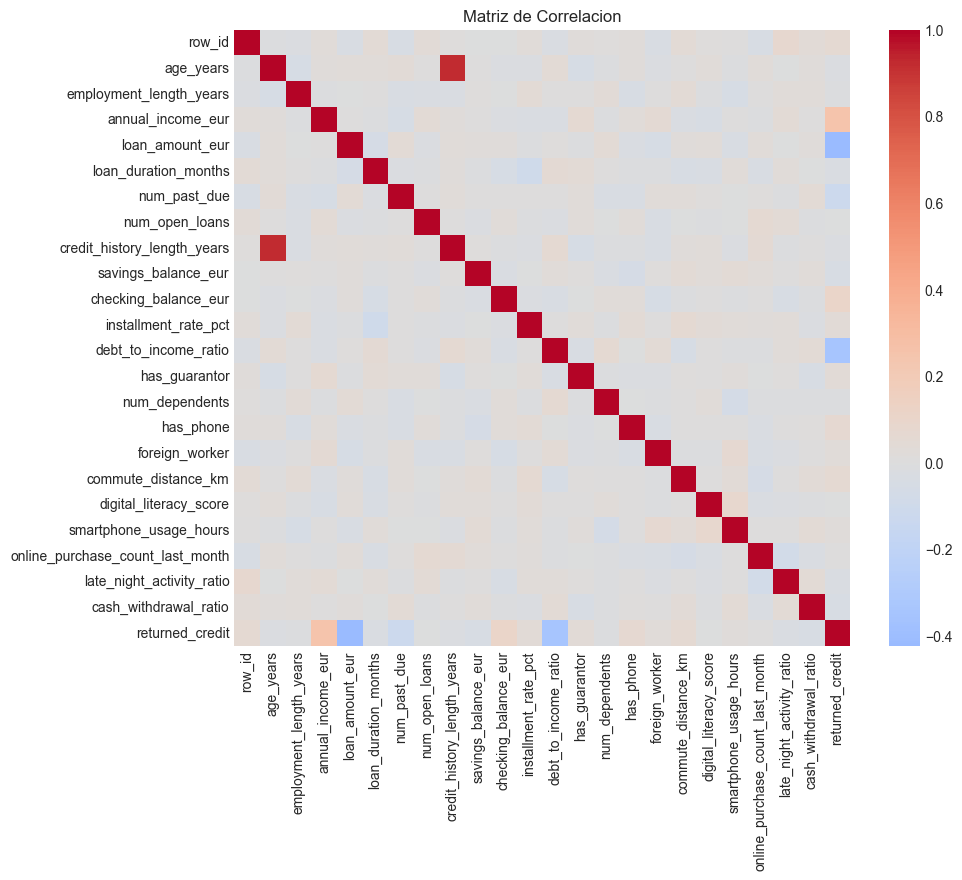

In [38]:
numeric_df = df.select_dtypes(include=[np.number])
corr = numeric_df.corr()
target_corr = corr['returned_credit'].sort_values(ascending=False)

print('Correlaciones con target:')
print(target_corr)

plt.figure(figsize=(10, 8))
sns.heatmap(corr, cmap='coolwarm', center=0, square=True, annot=False)
plt.title('Matriz de Correlacion')
plt.show()

## Apartado B: Preprocesamiento

In [39]:
X = df.drop(columns=['row_id', 'returned_credit'])
y = df['returned_credit']

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=42, stratify=y
)

print('DIVISION TRAIN/TEST:')
print(f'Train: {X_train.shape[0]}, Test: {X_test.shape[0]}')
print(f'Proporcion clases train: {y_train.value_counts(normalize=True).to_dict()}')
print(f'Proporcion clases test: {y_test.value_counts(normalize=True).to_dict()}')

categorical_features = X.select_dtypes(include=['object']).columns.tolist()
numeric_features = X.select_dtypes(include=[np.number]).columns.tolist()

print(f'\nFeatures categoricas: {len(categorical_features)}')
print(f'Features numericas: {len(numeric_features)}')

numeric_transformer = StandardScaler()
categorical_transformer = OneHotEncoder(handle_unknown='ignore', sparse_output=False, drop='first')

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features)
    ]
)

print('Preprocesador creado')

DIVISION TRAIN/TEST:
Train: 700, Test: 300
Proporcion clases train: {1: 0.7, 0: 0.3}
Proporcion clases test: {1: 0.7, 0: 0.3}

Features categoricas: 4
Features numericas: 22
Preprocesador creado


## Apartado C: Entrenamiento de Modelos Iniciales

**Modelos:** Logistic Regression (C=0.001), Decision Tree, KNN (k=1), Naive Bayes

In [40]:
print('ENTRENAMIENTO DE MODELOS INICIALES')

pipe_lr = Pipeline([
    ('preprocessor', preprocessor),
    ('classifier', LogisticRegression(C=0.001, max_iter=1000, random_state=42))
])
pipe_lr.fit(X_train, y_train)
print('- Logistic Regression (C=0.001): OK')

pipe_dt = Pipeline([
    ('preprocessor', preprocessor),
    ('classifier', DecisionTreeClassifier(random_state=42, class_weight='balanced'))
])
pipe_dt.fit(X_train, y_train)
print('- Decision Tree (sin limite profundidad): OK')

pipe_knn = Pipeline([
    ('preprocessor', preprocessor),
    ('classifier', KNeighborsClassifier(n_neighbors=1))
])
pipe_knn.fit(X_train, y_train)
print('- KNN (k=1): OK')

pipe_nb = Pipeline([
    ('preprocessor', preprocessor),
    ('classifier', GaussianNB())
])
pipe_nb.fit(X_train, y_train)
print('- Naive Bayes: OK')

models = {
    'Logistic Regression': pipe_lr,
    'Decision Tree': pipe_dt,
    'KNN': pipe_knn,
    'Naive Bayes': pipe_nb
}

ENTRENAMIENTO DE MODELOS INICIALES
- Logistic Regression (C=0.001): OK
- Decision Tree (sin limite profundidad): OK
- KNN (k=1): OK
- Naive Bayes: OK


## Apartado D: Evaluacion Inicial

In [41]:
results_initial = []

for name, model in models.items():
    y_pred_train = model.predict(X_train)
    y_pred_test = model.predict(X_test)
    y_prob_test = model.predict_proba(X_test)[:, 1]
    
    acc_train = accuracy_score(y_train, y_pred_train)
    acc_test = accuracy_score(y_test, y_pred_test)
    auc_test = roc_auc_score(y_test, y_prob_test)
    
    results_initial.append({
        'Modelo': name,
        'Acc_Train': round(acc_train, 4),
        'Acc_Test': round(acc_test, 4),
        'Diferencia': round(acc_train - acc_test, 4),
        'ROC-AUC': round(auc_test, 4)
    })

df_results = pd.DataFrame(results_initial)
print('RESULTADOS MODELOS INICIALES')
print(df_results.to_string(index=False))

RESULTADOS MODELOS INICIALES
             Modelo  Acc_Train  Acc_Test  Diferencia  ROC-AUC
Logistic Regression     0.7029    0.7000      0.0029   0.8608
      Decision Tree     1.0000    0.7767      0.2233   0.7262
                KNN     1.0000    0.7100      0.2900   0.6595
        Naive Bayes     0.7843    0.7300      0.0543   0.7660


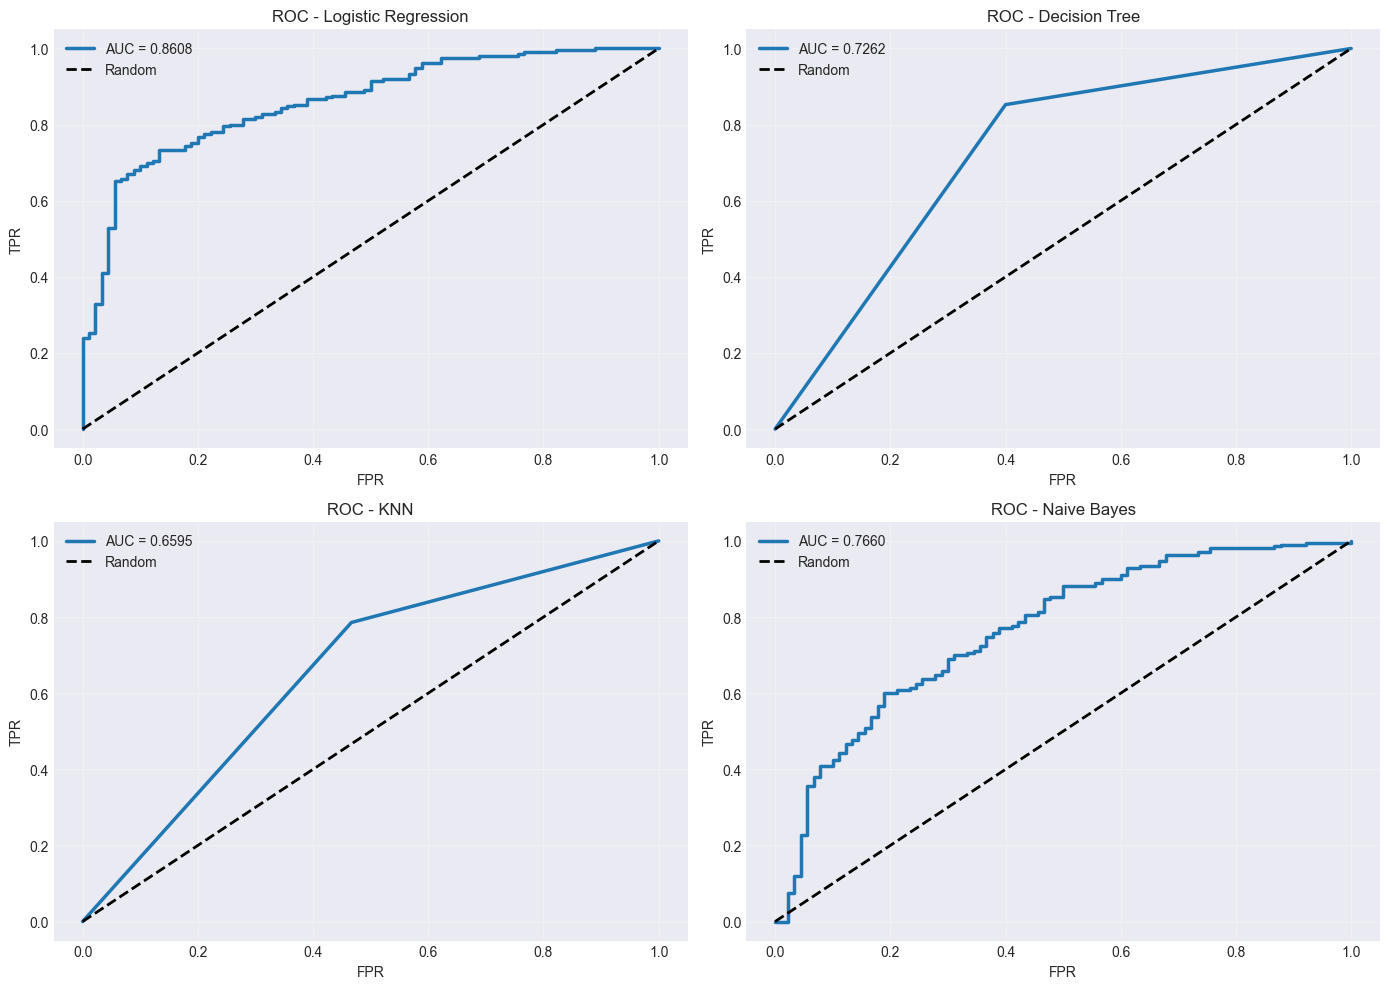

In [42]:
fig, axes = plt.subplots(2, 2, figsize=(14, 10))
axes = axes.ravel()

for idx, (name, model) in enumerate(models.items()):
    y_prob = model.predict_proba(X_test)[:, 1]
    fpr, tpr, _ = roc_curve(y_test, y_prob)
    auc = roc_auc_score(y_test, y_prob)
    
    axes[idx].plot(fpr, tpr, lw=2.5, label=f'AUC = {auc:.4f}')
    axes[idx].plot([0, 1], [0, 1], 'k--', lw=2, label='Random')
    axes[idx].set_xlabel('FPR')
    axes[idx].set_ylabel('TPR')
    axes[idx].set_title(f'ROC - {name}')
    axes[idx].legend()
    axes[idx].grid(alpha=0.3)

plt.tight_layout()
plt.show()